# Задача 1: "Идеальная игра": какие комбинации жанров/тегов/фич повышают популярность и качество игры


## Смысл:
Задача направлена на поиск закономерностей между жанрами, тегами и ключевыми игровыми фичами, которые влияют на популярность и качество игры. Анализ позволит выделить успешные паттерны — например, связку определённых жанров с социальными функциями или сюжетными элементами, — и понять, какие комбинации повышают интерес аудитории, вовлечённость и рейтинг.

Под интересом понимаем:

*   **интерес аудитории**: ratings_count, reviews_count, suggestions_count, added

*   **качество**: взвешенная оценка weighted_rating


Результаты помогут сформировать ориентиры для создания игры с максимальным потенциалом успеха.


## Как мы решаем задачу:

Мы будем опираться на очищенный датасет с уже посчитанным столбцом weighted_rating, в нем рассмотрим:

* Популярность/интерес: ratings_count, added

* Качество: weighted_rating

* Игровые характеристики: жанры (main_genre, genre_count), теги (tags)

**Что хотим построить и зачем:**

* Диаграммы распределения популярности по жанрам и тегам, чтобы получить топ самых популярных жанров и тегов у игр

* Столбчатые диаграммы средних рейтингов по жанрам и тегам, чтобы выделить наиболее качественные категории

* Топ-10 комбинацй жанров/тегов с наибольшим взвешенным рейтингом - чтобы конкретно показать "формулу успеха"

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import re, ast, textwrap
from collections import Counter

df_cleaned = pd.read_csv('dataset_final_cleaned.csv')

sns.set_style("whitegrid")

/tmp/ipython-input-532105696.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_stats, x="avg_weighted_rating", y="main_genre", palette="coolwarm", ax=axes[0])
/tmp/ipython-input-532105696.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tags_df, x="Average Weighted Rating", y="Tag", palette="viridis", ax=axes[1])


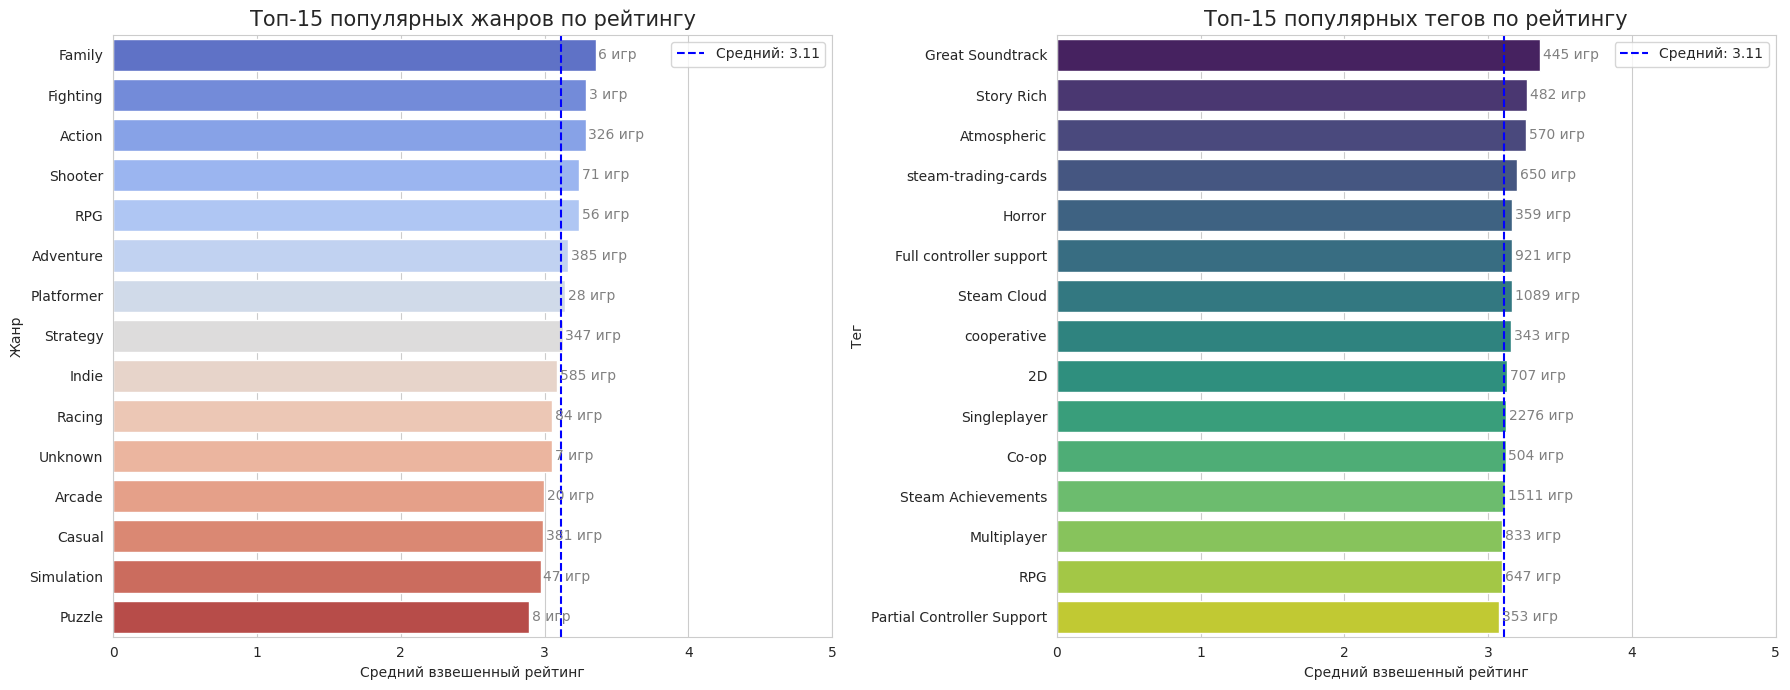

In [73]:
# группировка по жанрам
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(avg_weighted_rating=("weighted_rating", "mean"), n_games=("name", "count"))
    .sort_values("avg_weighted_rating", ascending=False)
    .head(15)
    .reset_index()
)

# статистика по тегам
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) > 0:
        rows.append({
            "Tag": tag,
            "Average Weighted Rating": subset["weighted_rating"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = pd.DataFrame(rows).sort_values("Average Weighted Rating", ascending=False).head(15)

# графики
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры
sns.barplot(data=genre_stats, x="avg_weighted_rating", y="main_genre", palette="coolwarm", ax=axes[0])

for i, (rating, count) in enumerate(zip(genre_stats["avg_weighted_rating"], genre_stats["n_games"])):
    axes[0].text(rating + 0.02, i, f"{count} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 популярных жанров по рейтингу", fontsize=15)
axes[0].set_xlabel("Средний взвешенный рейтинг")
axes[0].set_ylabel("Жанр")
axes[0].set_xlim(0, 5)

# 2 график: теги
sns.barplot(data=top_tags_df, x="Average Weighted Rating", y="Tag", palette="viridis", ax=axes[1])

for i, (rating, count) in enumerate(zip(top_tags_df["Average Weighted Rating"], top_tags_df["Number of Games"])):
    axes[1].text(rating + 0.02, i, f"{count} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 популярных тегов по рейтингу", fontsize=15)
axes[1].set_xlabel("Средний взвешенный рейтинг")
axes[1].set_ylabel("Тег")
axes[1].set_xlim(0, 5)

# линия среднего
mean_rating = df_cleaned["weighted_rating"].mean()
axes[0].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[0].legend()
axes[1].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-1888991299.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_stats, x="avg_added", y="main_genre", palette="coolwarm", ax=axes[0])
/tmp/ipython-input-1888991299.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tags_df, x="Average Added", y="Tag", palette="viridis", ax=axes[1])


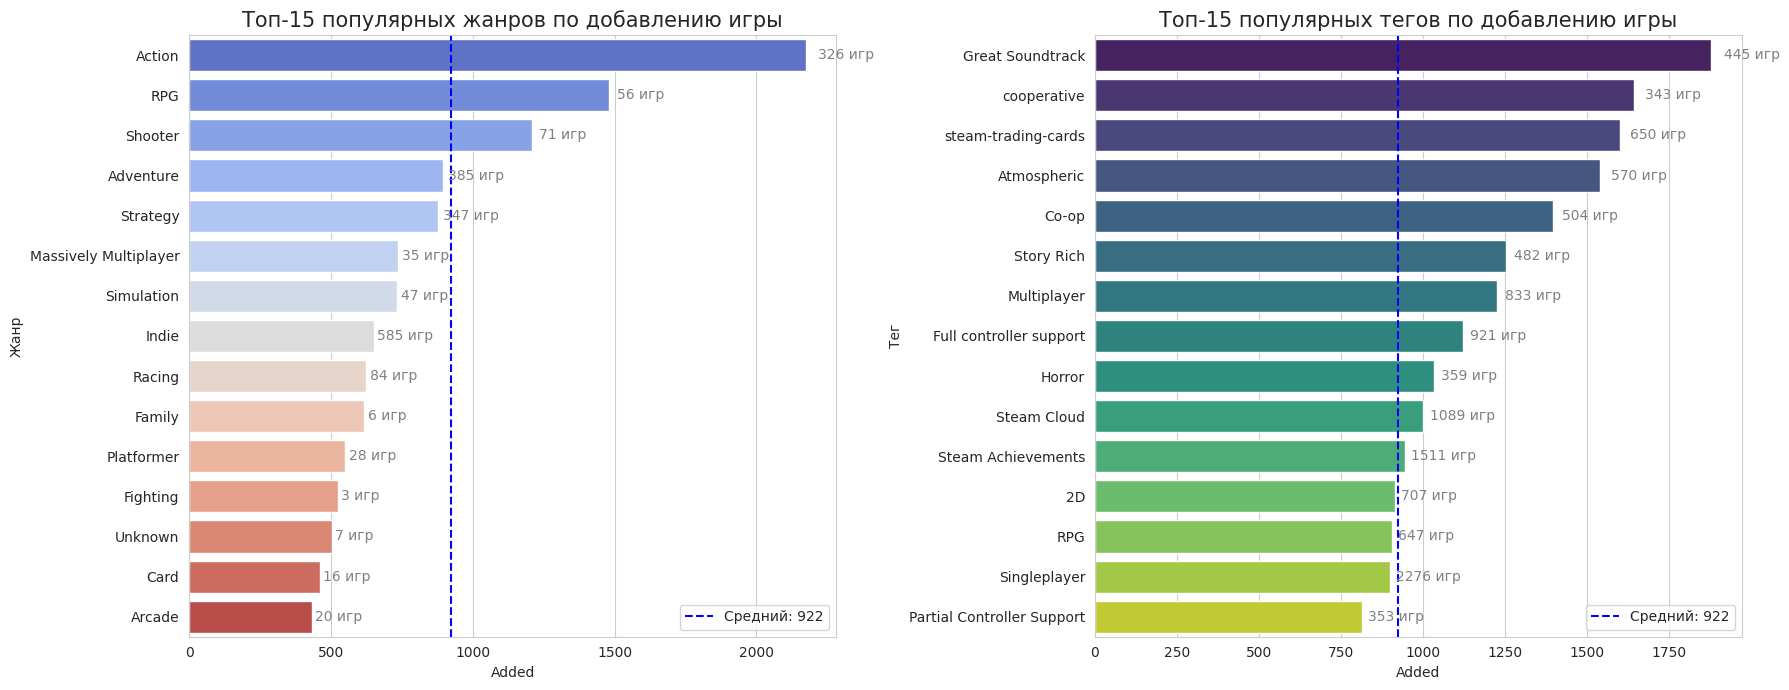

In [78]:
# группируем жанры по популярности
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(avg_added=("added", "mean"), n_games=("name", "count"))
    .sort_values("avg_added", ascending=False)
    .head(15)
    .reset_index()
)

# группируем теги по популярности
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) > 0:
        rows.append({
            "Tag": tag,
            "Average Added": subset["added"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = pd.DataFrame(rows).sort_values("Average Added", ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры по популярности
sns.barplot(data=genre_stats, x="avg_added", y="main_genre", palette="coolwarm", ax=axes[0])

for i, (added, count) in enumerate(zip(genre_stats["avg_added"], genre_stats["n_games"])):
    axes[0].text(added * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 популярных жанров по добавлению игры", fontsize=15)
axes[0].set_xlabel("Added")
axes[0].set_ylabel("Жанр")

# 2 график: теги по популярности
sns.barplot(data=top_tags_df, x="Average Added", y="Tag", palette="viridis", ax=axes[1])

for i, (added, count) in enumerate(zip(top_tags_df["Average Added"], top_tags_df["Number of Games"])):
    axes[1].text(added * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 популярных тегов по добавлению игры", fontsize=15)
axes[1].set_xlabel("Added")
axes[1].set_ylabel("Тег")

# линия среднего added
mean_added = df_cleaned["added"].mean()
axes[0].axvline(mean_added, color="blue", linestyle="--", label=f"Средний: {mean_added:.0f}")
axes[0].legend()
axes[1].axvline(mean_added, color="blue", linestyle="--", label=f"Средний: {mean_added:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-262311412.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-262311412.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


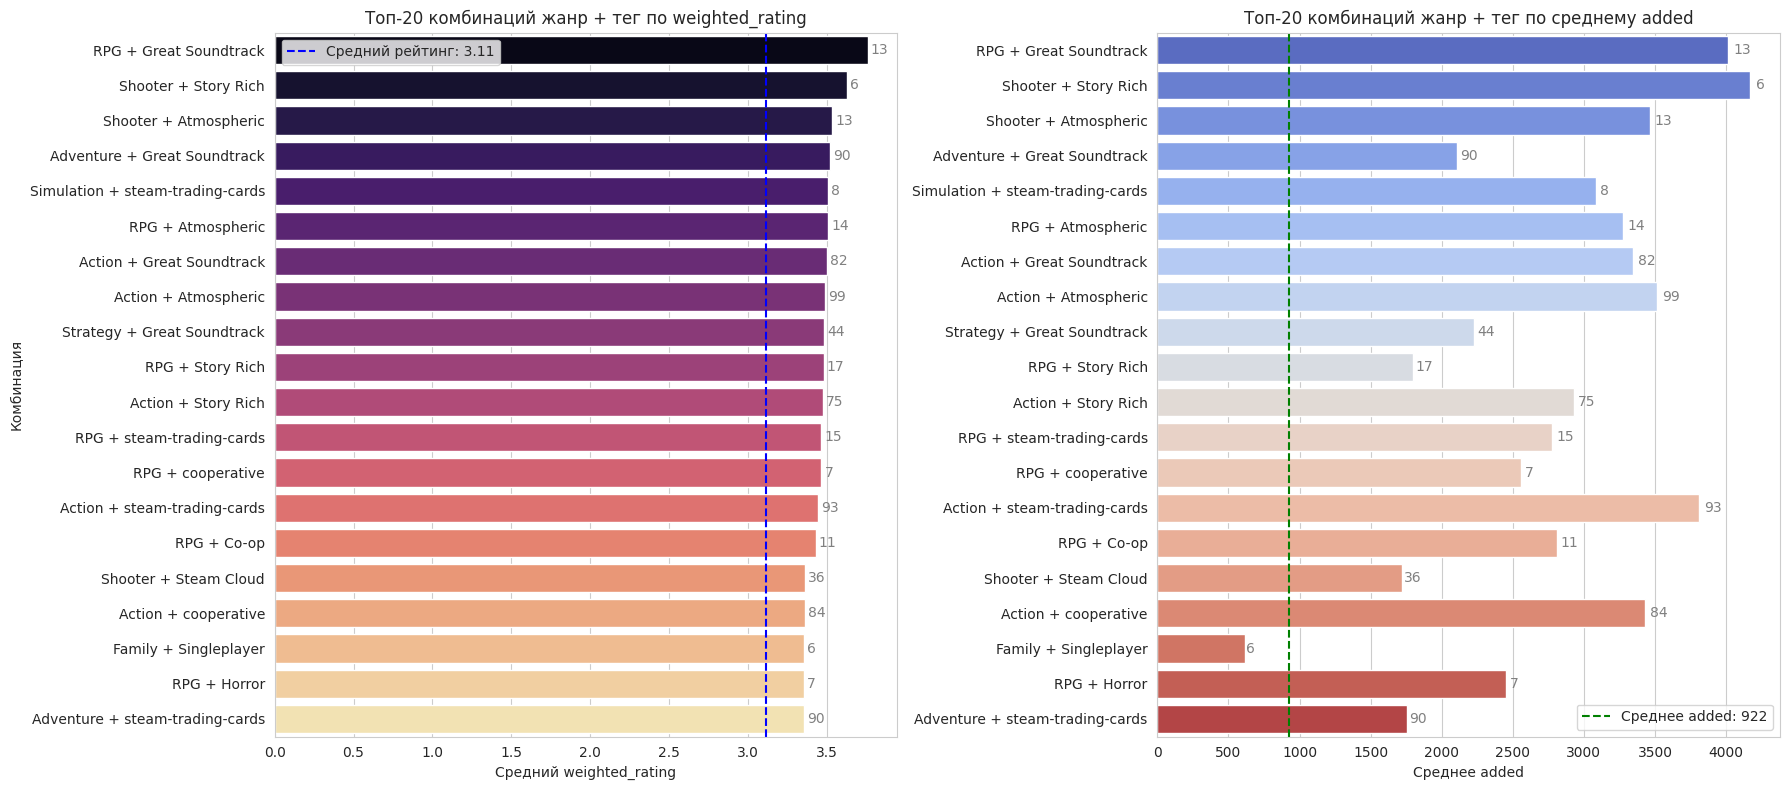

In [75]:
selected_genres = [
    "Action","RPG","Shooter","Adventure","Strategy","Massively Multiplayer",
    "Simulation","Indie","Racing","Family","Platformer","Fighting","Unknown",
    "Card","Arcade"]

selected_tags = [
    "Great Soundtrack","cooperative","steam-trading-cards","Atmospheric","Co-op",
    "Story Rich","Multiplayer","Full controller support","Horror","Steam Cloud",
    "Steam Achievements","2D","RPG","Singleplayer","Partial Controller Support"]

# подсчет статистики для комбинации
combo_stats = []
for genre in selected_genres:
    for tag in selected_tags:
        has_genre = df_cleaned["main_genre"] == genre
        has_tag = df_cleaned["tags"].apply(lambda ts: tag in ts if ts is not None else False)
        subset = df_cleaned[has_genre & has_tag]
        if len(subset) >= 5:
            combo_stats.append({
                "genre": genre,
                "tag": tag,
                "avg_weighted_rating": subset["weighted_rating"].mean(),
                "avg_added": subset["added"].mean(),
                "n_games": len(subset)
            })

combo_df = pd.DataFrame(combo_stats).sort_values("avg_weighted_rating", ascending=False)
top_combos = combo_df.head(20)

labels = top_combos.apply(lambda r: f"{r['genre']} + {r['tag']}", axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1 график: оценка рейтинга комбинаций
sns.barplot(
    data=top_combos,
    x="avg_weighted_rating",
    y=labels,
    palette="magma",
    ax=axes[0]
)
axes[0].set_title("Топ-20 комбинаций жанр + тег по weighted_rating")
axes[0].set_xlabel("Средний weighted_rating")
axes[0].set_ylabel("Комбинация")

# линия среднего рейтинга
mean_rating = df_cleaned["weighted_rating"].mean()
axes[0].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний рейтинг: {mean_rating:.2f}")
axes[0].legend()

# добавляем подписи количества игр
for i, v in enumerate(top_combos["avg_weighted_rating"]):
    axes[0].text(v + 0.02, i, f"{int(top_combos.iloc[i]['n_games'])}", color='grey', va='center')

# 2 график: кол-во добавлений у комбинации
sns.barplot(
    data=top_combos,
    x="avg_added",
    y=labels,
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("Топ-20 комбинаций жанр + тег по среднему added")
axes[1].set_xlabel("Среднее added")
axes[1].set_ylabel("")

# линия среднего added
mean_added = df_cleaned["added"].mean()
axes[1].axvline(mean_added, color="green", linestyle="--", label=f"Среднее added: {mean_added:.0f}")
axes[1].legend()

# добавляем подписи количества игр
for i, v in enumerate(top_combos["avg_added"]):
    axes[1].text(v * 1.01, i, f"{int(top_combos.iloc[i]['n_games'])}", color='grey', va='center')

plt.tight_layout()
plt.show()


/tmp/ipython-input-3834430866.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3834430866.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


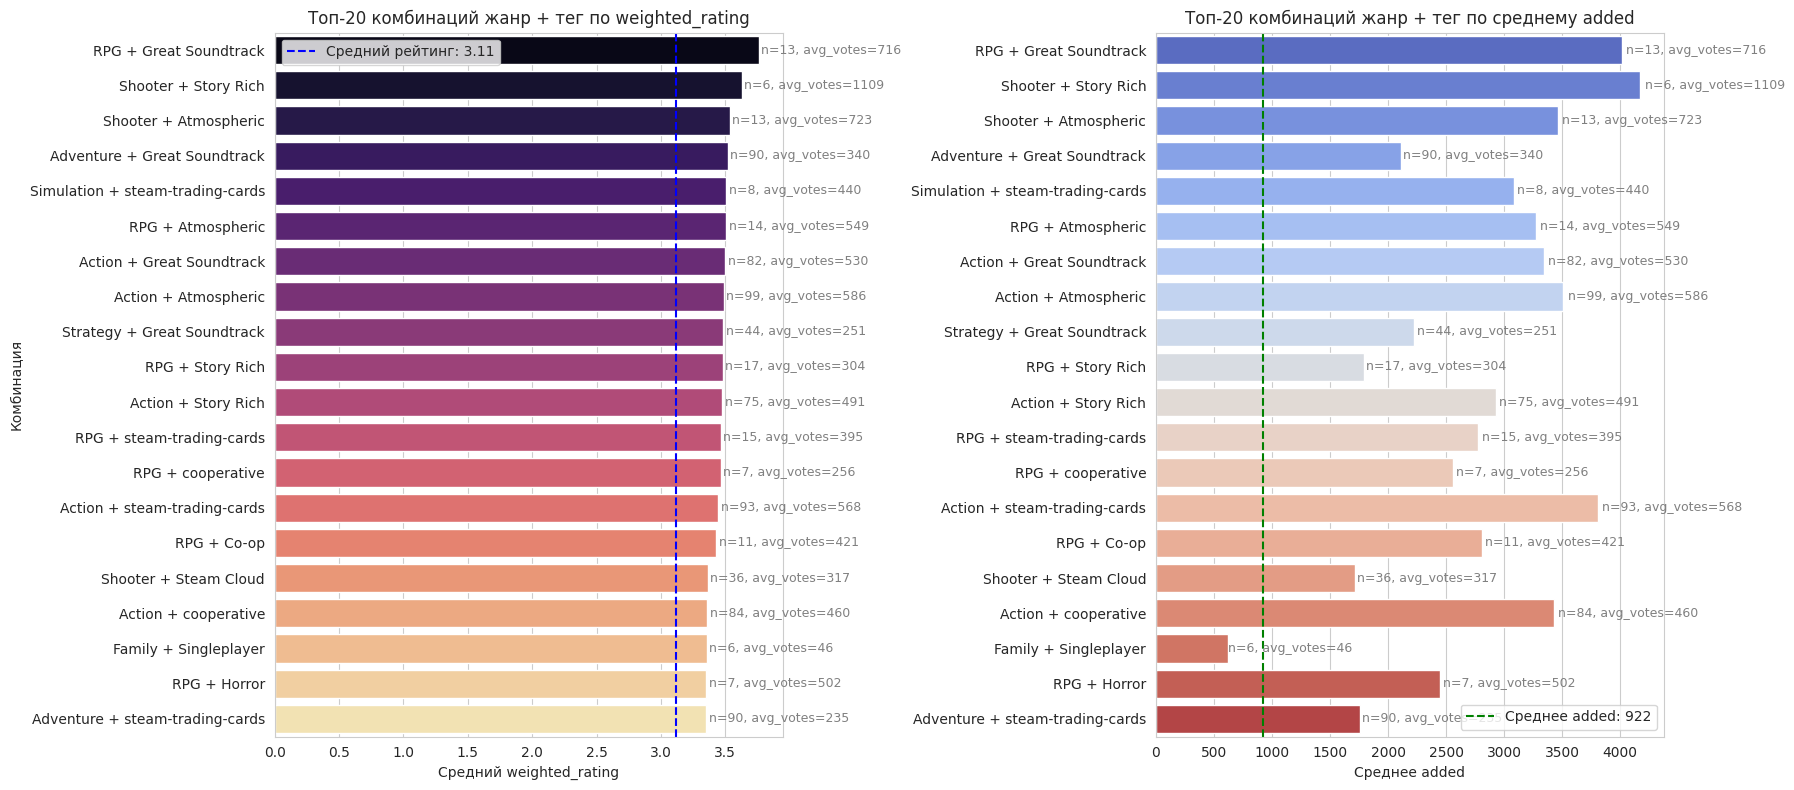

In [76]:
selected_genres = [
    "Action","RPG","Shooter","Adventure","Strategy","Massively Multiplayer",
    "Simulation","Indie","Racing","Family","Platformer","Fighting","Unknown",
    "Card","Arcade"]

selected_tags = [
    "Great Soundtrack","cooperative","steam-trading-cards","Atmospheric","Co-op",
    "Story Rich","Multiplayer","Full controller support","Horror","Steam Cloud",
    "Steam Achievements","2D","RPG","Singleplayer","Partial Controller Support"]

# подсчет статистики для комбинации
combo_stats = []
for genre in selected_genres:
    for tag in selected_tags:
        has_genre = df_cleaned["main_genre"] == genre
        has_tag = df_cleaned["tags"].apply(lambda ts: tag in ts if ts is not None else False)
        subset = df_cleaned[has_genre & has_tag]

        if len(subset) >= 5:
            combo_stats.append({
                "genre": genre,
                "tag": tag,
                "avg_weighted_rating": subset["weighted_rating"].mean(),
                "avg_added": subset["added"].mean(),
                "n_games": len(subset),
                "total_ratings": subset["ratings_count"].sum(),
                "avg_ratings_count": subset["ratings_count"].mean()
            })

combo_df = pd.DataFrame(combo_stats)

# сортируем и по рейтингу, и по количеству оценок
combo_df = combo_df.sort_values("avg_weighted_rating", ascending=False)
top_combos = combo_df.head(20)

labels = top_combos.apply(lambda r: f"{r['genre']} + {r['tag']}", axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1 график: оценка рейтинга комбинаций
sns.barplot(
    data=top_combos,
    x="avg_weighted_rating",
    y=labels,
    palette="magma",
    ax=axes[0]
)
axes[0].set_title("Топ-20 комбинаций жанр + тег по weighted_rating")
axes[0].set_xlabel("Средний weighted_rating")
axes[0].set_ylabel("Комбинация")

# линия среднего рейтинга
mean_rating = df_cleaned["weighted_rating"].mean()
axes[0].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний рейтинг: {mean_rating:.2f}")
axes[0].legend()

# подписи: n игр и среднее число оценок
for i, (v, n, rc) in enumerate(
    zip(top_combos["avg_weighted_rating"], top_combos["n_games"], top_combos["avg_ratings_count"])
):
    axes[0].text(
        v + 0.02,
        i,
        f"n={int(n)}, avg_votes={int(rc)}",
        color="grey",
        va="center",
        fontsize=9
    )

# 2 график: среднее added по комбинациям
sns.barplot(
    data=top_combos,
    x="avg_added",
    y=labels,
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("Топ-20 комбинаций жанр + тег по среднему added")
axes[1].set_xlabel("Среднее added")
axes[1].set_ylabel("")

# линия среднего added
mean_added = df_cleaned["added"].mean()
axes[1].axvline(mean_added, color="green", linestyle="--", label=f"Среднее added: {mean_added:.0f}")
axes[1].legend()

# подписи: n игр и среднее число оценок
for i, (v, n, rc) in enumerate(
    zip(top_combos["avg_added"], top_combos["n_games"], top_combos["avg_ratings_count"])
):
    axes[1].text(
        v * 1.01,
        i,
        f"n={int(n)}, avg_votes={int(rc)}",
        color="grey",
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()


/tmp/ipython-input-2893905470.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


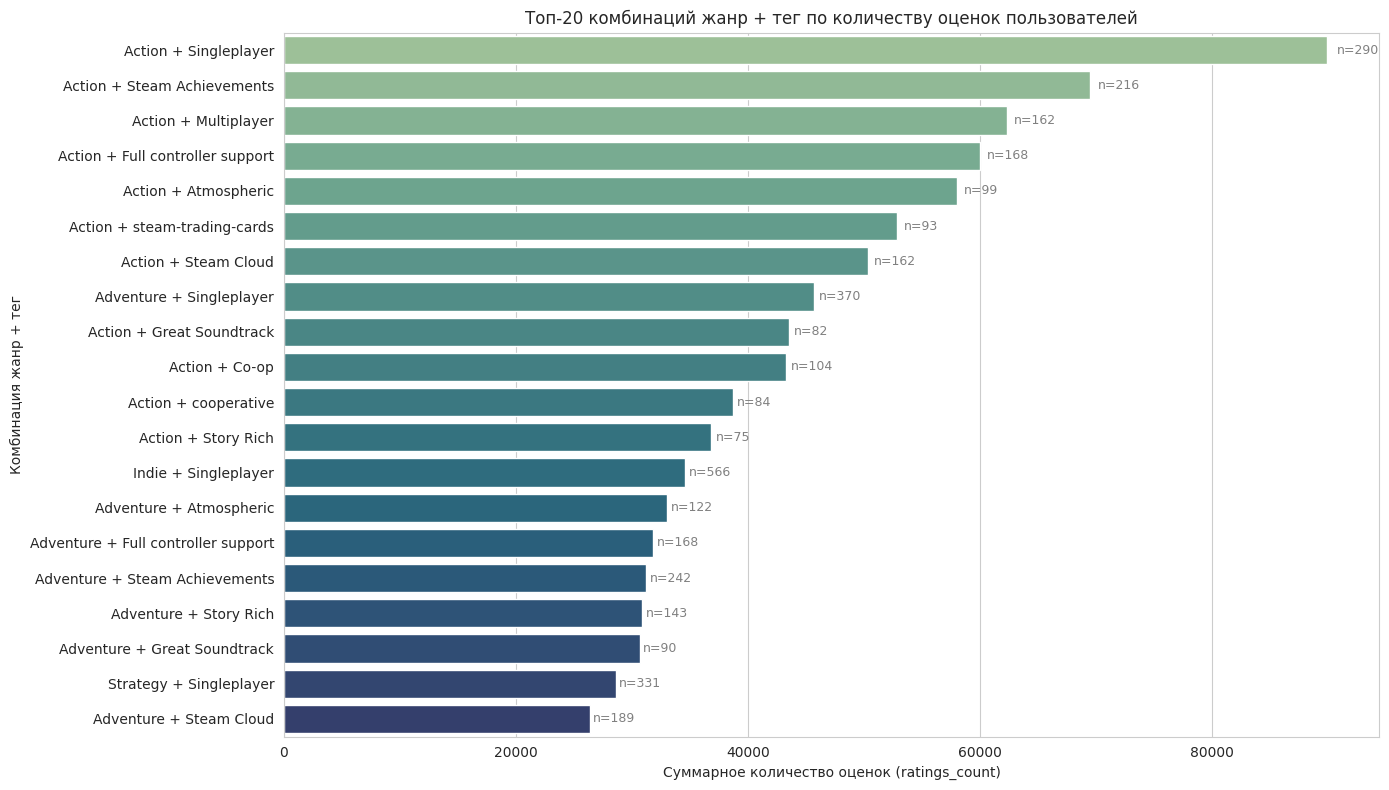

In [84]:
combo_unique = (
    combo_df
    .groupby(["genre", "tag"], as_index=False)
    .agg(
        total_ratings=("total_ratings", "sum"),
        n_games=("n_games", "sum")
    )
)

combo_top_votes = combo_unique.sort_values("total_ratings", ascending=False).head(20)

labels = combo_top_votes.apply(lambda r: f"{r['genre']} + {r['tag']}", axis=1)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=combo_top_votes,
    x="total_ratings",
    y=labels,
    palette="crest"
)

plt.xlabel("Суммарное количество оценок (ratings_count)")
plt.ylabel("Комбинация жанр + тег")
plt.title("Топ-20 комбинаций жанр + тег по количеству оценок пользователей")

for i, (x, n) in enumerate(zip(combo_top_votes["total_ratings"], combo_top_votes["n_games"])):
    plt.text(x * 1.01, i, f"n={int(n)}", va="center", color="gray", fontsize=9)

plt.tight_layout()
plt.show()


# Выводы и бизнес-инсайты

## Выводы по результатам анализа (RAWG + Steam)

Проведенный анализ жанров, тегов и их комбинаций показывает устойчивые паттерны пользовательского интереса, которые воспроизводятся сразу по нескольким метрикам: количеству добавлений в библиотеку, числу пользовательских оценок и среднему взвешенному рейтингу.

С точки зрения популярности жанров, наибольший охват аудитории демонстрируют Action, Adventure и RPG. Эти жанры стабильно находятся в верхней части рейтингов по среднему количеству добавлений и количеству оценок пользователей, что указывает на высокий спрос и широкую потенциальную аудиторию. При этом Indie выступает не столько как жанр, сколько как формат: комбинации Indie + Singleplayer и Indie + системные теги (Achievements, Steam Cloud) собирают значительное количество пользовательских взаимодействий.

Анализ тегов показывает, что наивысшие средние рейтинги характерны для игр с акцентом на Great Soundtrack, Story Rich и Atmospheric. Эти теги регулярно входят в топ по взвешенному рейтингу и часто встречаются в наиболее успешных комбинациях жанр + тег. Это указывает на важность эмоционального восприятия игры и целостного пользовательского опыта, а не только базовых игровых механик.

Отдельно стоит отметить доминирование Singleplayer-игр. Они лидируют по количеству оценок пользователей и демонстрируют устойчивые показатели добавлений, опережая многие мультиплеерные комбинации. Кооперативные и мультиплеерные теги также популярны, однако требуют большего объема поддержки и чаще зависят от жизненного цикла онлайн-сообщества.

Комбинации жанров и тегов с наилучшим соотношением рейтинга и популярности включают RPG + Great Soundtrack, Shooter + Story Rich, Action + Atmospheric и Adventure + Great Soundtrack. Эти связки демонстрируют сбалансированное сочетание пользовательского интереса и высокого качества восприятия.

В то же время узкие жанры (Fighting, Arcade, Card) и проекты без выраженного атмосферного или нарративного акцента значительно реже попадают в верхние части рейтингов, что делает их более рискованными с точки зрения массового рынка.

## Бизнес-инсайты для компании

С точки зрения продуктовой стратегии, полученные данные указывают на целесообразность фокусировки на проектах среднего масштаба в популярных жанрах с четко выраженным пользовательским ценностным предложением. Для студии с ограниченными ресурсами наиболее рациональной является разработка Singleplayer-игры в жанрах Action, Adventure или RPG с упором на атмосферу, музыку и нарратив.

Инвестиции в качественный саундтрек и проработанный мир оказывают прямое влияние на пользовательские оценки и восприятие продукта. В отличие от сложных мультиплеерных механик, такие элементы масштабируются лучше и не требуют постоянной серверной и контентной поддержки после релиза.

Дополнительным фактором повышения привлекательности продукта является наличие базовых Steam-функций: достижений, облачных сохранений и поддержки контроллеров. Эти элементы не являются уникальными конкурентными преимуществами, однако их отсутствие может негативно повлиять на решение пользователя о покупке или добавлении игры в библиотеку.

Таким образом, оптимальной стратегией является создание цельного, эмоционально насыщенного игрового опыта в популярном жанре, ориентированного на одиночное прохождение и широкую аудиторию платформ Steam и RAWG.

## Концепты игр, соответствующие выявленным паттернам

**Концепт 1. Narrative Action Adventure с упором на атмосферу**
Singleplayer Action-Adventure от третьего лица с линейным, но насыщенным окружением. Основной акцент сделан на атмосферу, визуальный стиль и саундтрек, который сопровождает ключевые сюжетные моменты. История подается через окружение, диалоги и небольшие игровые события. Проект ориентирован на умеренную продолжительность и высокую степень полировки.

**Концепт 2. Indie RPG с сильным нарративом и музыкой**
Однопользовательская RPG с элементами исследования и выбора, влияющего на развитие сюжета. Ключевые теги: Story Rich, Great Soundtrack, Atmospheric. Боевая система упрощена, чтобы снизить сложность разработки, при этом основное внимание уделяется миру, персонажам и эмоциональному вовлечению игрока.

**Концепт 3. Story-driven Shooter с одиночной кампанией**
Shooter с фокусом на сюжет и постановку, рассчитанный исключительно на одиночное прохождение. Мультиплеер отсутствует, что позволяет сосредоточить ресурсы на уровне дизайна, сценарии и аудиосоставляющей. Проект ориентирован на игроков, ищущих компактный, но запоминающийся игровой опыт.


## Концепты для идеальной игры

### Концепт 1
Narrative Action Adventure с упором на атмосферу и звук

Описание концепта
Одиночная Action / Adventure-игра, ориентированная на исследование мира и эмоциональное погружение. Геймплей не перегружен сложными механиками и строится вокруг перемещения, взаимодействия с окружением и ограниченного, но выразительного экшена. Ключевая ценность для игрока это атмосфера, визуальный стиль и музыка, усиливающая ощущение мира.

Почему концепт подтверждается данными

- Action и Adventure входят в топ жанров по добавлениям

- Теги Atmospheric и Great Soundtrack показывают высокие средние рейтинги

- Комбинации Adventure + Great Soundtrack и Action + Atmospheric стабильно находятся в топ-20

- Singleplayer снижает риски разработки и поддержки

**Гипотеза**
Игры этого типа хорошо заходят широкой аудитории, даже без высокой реиграбельности, за счет целостного впечатления и сильных эмоций.

Примеры реальных игр (по смыслу, не обязательно из датасета):
Journey, Firewatch, Inside, Limbo, ABZÛ

### Концепт 2
Story-driven Indie RPG с акцентом на нарратив и выбор

Описание концепта
Небольшая по масштабу RPG, где основная механика это принятие решений и развитие истории. Боевая система упрощенная или пошаговая, чтобы снизить стоимость разработки. В центре внимания персонажи, диалоги, лор и саундтрек, который поддерживает эмоциональные пики сюжета.

Почему концепт подтверждается данными

- RPG стабильно в топе по популярности

- RPG + Great Soundtrack и RPG + Story Rich входят в лучшие комбинации по рейтингу

- Story Rich и Atmospheric имеют рейтинг выше среднего

- Indie-формат хорошо масштабируется под студенческую команду

**Гипотеза**
Даже при ограниченной графике такие игры получают высокие оценки за счет сценария и музыки.

Примеры реальных игр:
Undertale, Disco Elysium, To the Moon, OMORI, Citizen Sleeper

### Концепт 3
Singleplayer Shooter с фокусом на сюжет и постановку

Описание концепта
Shooter с одиночной кампанией, без мультиплеера. Основной акцент сделан на историю, постановку сцен и атмосферу. Геймплей линейный или полу-линейный, что позволяет контролировать темп повествования и снизить сложность баланса.

Почему концепт подтверждается данными

- Shooter стабильно высок по добавлениям

- Shooter + Story Rich и Shooter + Atmospheric показывают хорошие рейтинги

- Отказ от мультиплеера снижает издержки поддержки

- Подходит для сравнительно коротких, но запоминающихся проектов

**Гипотеза**
Игроки готовы покупать сюжетные шутеры ради опыта, даже если они короткие.

Примеры реальных игр:
Spec Ops: The Line, Metro 2033, BioShock, Singularity, Titanfall 2 (кампания)

# Анализ графиков (старый текст)


Семейные игры и файтинги возглавляют рейтинг, что свидетельствует об их высоком качестве и удовлетворенности игроков. При этом массовые многопользовательские и образовательные проекты демонстрируют наименьшие оценки, что может указывать на более высокую критичность их аудитории.

Теги, связанные с глубиной контента (Story Rich, Atmospheric), показывают наивысшие оценки, что подчеркивает важность нарратива и атмосферы для игроков. Технические особенности вроде достижений Steam и мультиплеера имеют сравнительно меньший вес в формировании финального рейтинга.

\
Анализ по наивысшим рейтингом с количеством игр > 5.
Наивысший рейтинг имеет жанр семейных игр, хотя количество игр небольшое. При этом массовые жанры Indie и Action демонстрируют стабильно хорошие оценки при бОльшем количестве игр, что говорит о стабильном качестве в этих категориях.

Теги overlay и Beat 'em up возглавляют рейтинг, что указывает на высокую оценку нишевых игровых механик. Особенно показательно, что тег Classic показывает такой высокий рейтинг, несмотря на большое количество оценок.

\
Топ-20 комбинаций по тегам и жанрам

Комбинация с тегом Classic лидируют как по среднему рейтингу, так и по количеству добавлений, что вполне очевидно: классичсекие игры для каждого жанра не теряют свою устойчивость со временем. Технологические теги также демонстрируют сильные показатели, подчеркивая значимость технической реализации и удобства для игроков.

Особенно взрывными оказались комбинации классические игры в таких жанрах, как Adventure, Strategy, Racing и Action и игры с наличием контроллера в таких жанрах, как Shooter, Action, Simulation и прочие. Выделилась среди этой категории комбинация Indie + Metroidvania. Именно у небольших компаний хорошо получается строить игры, основанные на самостоятельном прохождении.

Высокий рейтинг коррелирует с количеством добавлений в библиотеку: есть игры, которые показали смешные показатели и по рейтингу, и по добавлению. Это значит то, что игры с высоким качеством, чаще становятся востребованными.

## Вывод по задаче

Комбинации жанров и тегов действительно напрямую влияют на популярность и качество игры. Игры с определёнными жанрами и тегами получают более высокие оценки (weighted_rating) и больше добавлений в библиотеку пользователей (added).

Подтверждение гипотезы:

Наличие дополнительных функций повышает качество игры для любого типа игр, улучшая качество в целом.

Наибольший средний рейтинг имеют комбинации с тегом Classic для жанров Racing, RPG, Strategy, Action, Casual.

Поддержка контроллера (controller support) повышает как рейтинг, так и популярность, особенно для динамичных жанров: Action, Shooter, Adventure, Platformer.

Нишевые комбинации для инди-игр (Cyberpunk, Metroidvania, Captions available) стабильно показывают хороший рейтинг, хотя массовой популярности у них меньше.

## Бизнес-инсайты для команды разработчиков

Наиболее подходящими жанрами для создания успешной игры являются Action, RPG, Strategy, Adventure и Racing. Ключевые теги для них: classic и controller support. Стоит ориентироваться на механику игр, проверенных временем и иметь возможность управлять игрой с помощью контроллера.

Если игра будет разрабатываться небольшой студией или одним человеком (Indie), то стоит ориентироваться на жанр Metroidvania - наличие нелинейной карты, где прогресс зависит от получения новых способностей и открытии новых областей; Ciberpunk (стилистика, основанная на высоких технологиях и низком уровне жизни, влиянии корпораций, антиутопия) и просто иметь наличие субтитров (Captions available) вместо реплик.

Фокус на пользовательский комфорт и опыт:
Вовлеченность и добавления могут повышать такие функции, как поддержка контроллера, облачное сохранение игры, акцент на богатую историю и атмосферу, наличие оверлея, статус эксклюзивности, наличие полноэкранного видео как основного элемента геймплеяю

\
Стратегия выхода:

Достичь получение высоких оценок пользователей можно ни одним способом:

* Ориентироваться на Classic-жанры и перенимать лучшие практики у топовых игр (как Portal 2)

* Улучшать качество игры, учитывая наличие специальных функций игры

* Создавать игру в необычных жанрах, ориентируясь на бюджет компании.  
